In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(suppress=True)
import pandas as pd
from tqdm import tqdm
import h5py

In [2]:
def findpair(ID2,history,possiblecombos):
    if ID2 in list(possiblecombos.ID1):
        #need to consider that there may be more than one possibility for an end point
        #ended up taking the first value because it's the closest in time
        return(findpair(list(possiblecombos.loc[possiblecombos.ID1==ID2].ID2)[0],history+[ID2],possiblecombos))
    else:
        return(history+[ID2])
    
def findpairreverse(ID1,history,possiblecombos):
    if ID1 in list(possiblecombos.ID2):
        #need to consider that there may be more than one possibility for an end point
        #ended up taking the first value because it's the closest in time
        return(findpairreverse(list(possiblecombos.loc[possiblecombos.ID2==ID1].ID1)[0],history+[ID1],possiblecombos))
    else:
        return(history+[ID1])

Import npy file of form (number of points,4) where the second dimension gives 0:id, 1:time, 2:x pos, 3:y pos

In [3]:
tracks=np.load("../../../../../Data/202304051_idtxy.npy")

Finds the distances between consecutive points within and ID and plots the distribution:

In [4]:
dists=np.zeros((np.shape(np.unique(tracks[:,0],return_counts=True))[1],
                np.max(np.unique(tracks[:,0],return_counts=True)[1])))
for i in range(len(np.unique(tracks[:,0]))):
    temptracks=tracks[tracks[:,0]==np.unique(tracks[:,0])[i]]
    for j in range(1,len(temptracks[:,0])):
        dists[i,j]=np.linalg.norm((temptracks[j,2]-temptracks[j-1,2],temptracks[j,3]-temptracks[j-1,3]))

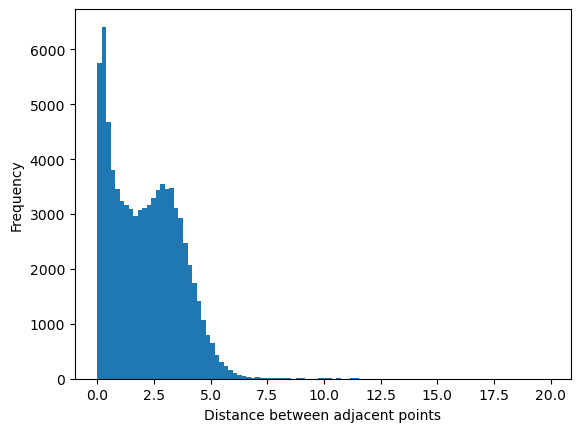

In [5]:
plt.xlabel("Distance between adjacent points")
plt.ylabel("Frequency")
plt.hist(dists[dists!=0],bins=100);

Can't simply remove IDs with little movement because they could be missatributed and actually be part of adjacent worms.

Might be easier to use a pandas dataframe for easier manipulation:

In [6]:
tracksdf=pd.DataFrame(tracks, columns = ['ID','time','x','y'])

We can see that all IDs have consecutive times:

In [7]:
for ID in np.unique(tracksdf.ID):
    l=tracksdf.loc[tracksdf.ID==ID].time.astype(int)
    if not (sorted(l) == list(range(min(l), max(l)+1))): print("Non consecutive")

First, need to make an algorithm that can throw out slow moving worms. We can calculate this by looking a the average angle between points. Slow moving worms will have smaller angles between points.

In [8]:
meanangles=pd.DataFrame(columns=["meanangle"],index=np.unique(tracksdf.ID).astype(int))
for ID in tqdm(np.unique(tracksdf.ID).astype(int)):
    if len(tracksdf.loc[tracksdf.ID==ID])<6:
        meanangles.loc[ID]=120
        continue
    start=int(min(tracksdf.loc[tracksdf.ID==ID].time))
    end=int(max(tracksdf.loc[tracksdf.ID==ID].time))
    #takes three consecutive points in time and calculates the engle between them
    a=tracksdf.loc[(tracksdf.ID==ID)
                   &(start<tracksdf.time)
                   &(tracksdf.time<end-2)]
    b=tracksdf.loc[(tracksdf.ID==ID)
                   &(start+1<tracksdf.time)
                   &(tracksdf.time<end-1)]
    c=tracksdf.loc[(tracksdf.ID==ID)
                   &(start+2<tracksdf.time)
                   &(tracksdf.time<end)]
    meanangles.loc[ID]=np.mean(np.abs(np.degrees(np.arctan2(np.asarray(c.y)-np.asarray(b.y),
                                                                      np.asarray(c.x)-np.asarray(b.x))
                                                           - np.arctan2(np.asarray(a.y)-np.asarray(b.y),
                                                                        np.asarray(a.x)-np.asarray(b.x)))))
    
tracksdf=tracksdf[np.isin(np.asarray(tracksdf.ID),meanangles[meanangles.meanangle>=120].index)]

100%|█████████████████████████████████████████████████████████████████████████████| 1290/1290 [00:02<00:00, 543.07it/s]


Idea for algorithm: find IDs that begin/end on near adjacent times:

In [9]:
#creates dataframe with start and end times for each ID
startend=pd.DataFrame(columns=["start","end"])
for ID in np.unique(tracksdf.ID).astype(int):
    startend.loc[ID,:]=int(np.min(tracksdf.loc[tracksdf.ID==ID].time)),int(np.max(tracksdf.loc[tracksdf.ID==ID].time))
startend.astype(int);

In [10]:
#gets all possible combinations of two indexes within 10 frames and 20 distance
possiblecombos=pd.DataFrame(columns=["ID1","ID2","end","start"])#,"dist"])
for ID in tqdm(np.unique(tracksdf.ID)):
    endindex=startend.loc[ID].end
    endlocation=tracksdf.loc[(tracksdf.ID==ID) & (tracksdf.time==endindex),["x","y"]].values
    for end in range(endindex,endindex+10):
        if end+1 in list(startend.start):
            for startID in startend.index[startend.start==end+1]:
                startlocation=tracksdf.loc[(tracksdf.ID==startID) & (tracksdf.time==end+1),["x","y"]].values
                if np.linalg.norm(startlocation-endlocation) < 20:
                    possiblecombos.loc[len(possiblecombos.index)] = [int(ID),startID,endindex,end+1]#,np.linalg.norm(startlocation-endlocation)] 
                    #print("first ID: "+str(int(ID))+", second ID: "+str(startID)+", difference in times: "+str(endindex),str(end+1)+", distance: "+str(np.linalg.norm(startlocation-endlocation)))

100%|█████████████████████████████████████████████████████████████████████████████| 1137/1137 [00:06<00:00, 177.55it/s]


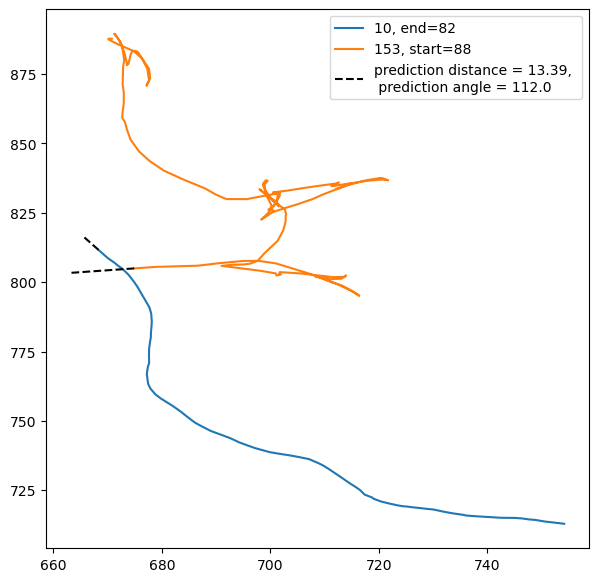

In [11]:
for i in [5]:
    f=plt.figure(figsize=(7,7)) #creates the figure
    
    ID1=int(possiblecombos[possiblecombos.index==i].ID1)#stores IDs for the start and end track
    ID2=int(possiblecombos[possiblecombos.index==i].ID2)#stores IDs for the start and end track
    
    #finds the difference between the last points of ID1
    diff1=(tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end-1)][["x","y"]].values[0])
    
    
    #finds the difference between the first points of ID2
    diff2=(tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start+1)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start)][["x","y"]].values[0])

    #plots the two IDs
    plt.plot(tracksdf[tracksdf.ID==ID1].x,
             tracksdf[tracksdf.ID==ID1].y,label=str(ID1)+", end="+str(startend.loc[ID1].end))
    plt.plot(tracksdf[tracksdf.ID==ID2].x,
             tracksdf[tracksdf.ID==ID2].y,label=str(ID2)+", start="+str(startend.loc[ID2].start))

    #finds the location of the end of ID1
    ID1end=tracksdf[(tracksdf.ID==ID1)&(tracksdf.time==max(tracksdf[tracksdf.ID==ID1].time))][["x","y"]].values[0]
    
    #finds the location of the start of ID2
    ID2start=tracksdf[(tracksdf.ID==ID2)&(tracksdf.time==min(tracksdf[tracksdf.ID==ID2].time))][["x","y"]].values[0]
    
    
    #predicts where the worm should be (halfway)- gives a starting point of the end of ID1 and an ending point that is predicted
    prediction1=np.stack([ID1end,ID1end+diff1*(int(possiblecombos[possiblecombos.index==i].start)
                                              -int(possiblecombos[possiblecombos.index==i].end))/2])
    
    
    #predicts where the worm should be (halfway)- gives a starting point of the end of ID1 and an ending point that is predicted
    prediction2=np.stack([ID2start,ID2start-diff2*(int(possiblecombos[possiblecombos.index==i].start)
                                                  -int(possiblecombos[possiblecombos.index==i].end))/2])
    
    #finds the distance between the predicted points
    dist = np.sqrt(np.sum(np.square(prediction1[1]-prediction2[1])))
    angle = np.min([np.abs(np.arctan2(diff1[1],diff1[0])
                           -np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
                    360-np.abs(np.arctan2(diff1[1],diff1[0])
                               -np.arctan2(diff2[1],diff2[0]))*(180/np.pi)])
    
    #plots the prediction line
    plt.plot(prediction1[:,0],prediction1[:,1],color="black",linestyle="dashed")

    
    plt.plot(prediction2[:,0],prediction2[:,1],color="black",linestyle="dashed",
             label="prediction distance = "+str(np.round(dist,2))+
             ", \n prediction angle = "+str(np.round(angle)))
    
    #print(diff1)
    #print(diff2)
    #print(np.arctan2(diff1[1],diff1[0])*(180/np.pi))
    #print(np.arctan2(diff2[1],diff2[0])*(180/np.pi))
    
    #print(np.min([np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
    #              360-np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi)]))
    plt.legend()
    plt.show()

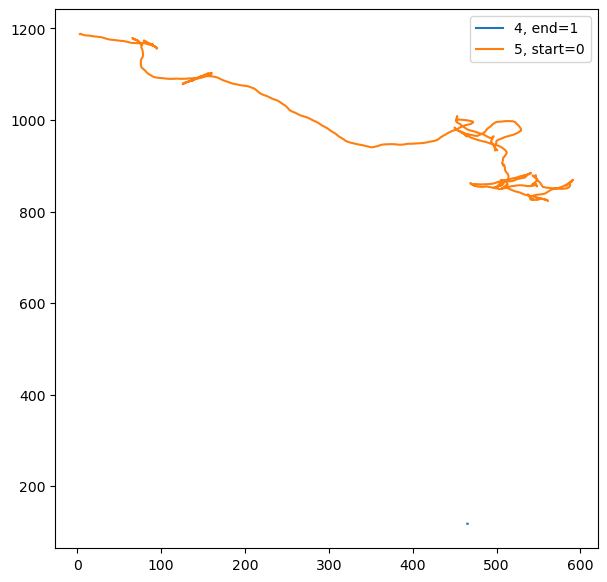

In [12]:
f=plt.figure(figsize=(7,7)) #creates the figure

ID1=4
ID2=5

#finds the difference between the last points of ID1
diff1=(tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end)][["x","y"]].values[0]
       -tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end-1)][["x","y"]].values[0])


#finds the difference between the first points of ID2
diff2=(tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start+1)][["x","y"]].values[0]
       -tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start)][["x","y"]].values[0])

#plots the two IDs
plt.plot(tracksdf[tracksdf.ID==ID1].x,
         tracksdf[tracksdf.ID==ID1].y,label=str(ID1)+", end="+str(startend.loc[ID1].end))
plt.plot(tracksdf[tracksdf.ID==ID2].x,
         tracksdf[tracksdf.ID==ID2].y,label=str(ID2)+", start="+str(startend.loc[ID2].start))

#print(diff1)
#print(diff2)
#print(np.arctan2(diff1[1],diff1[0])*(180/np.pi))
#print(np.arctan2(diff2[1],diff2[0])*(180/np.pi))

#print(np.min([np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
#              360-np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi)]))
plt.legend()
plt.show()

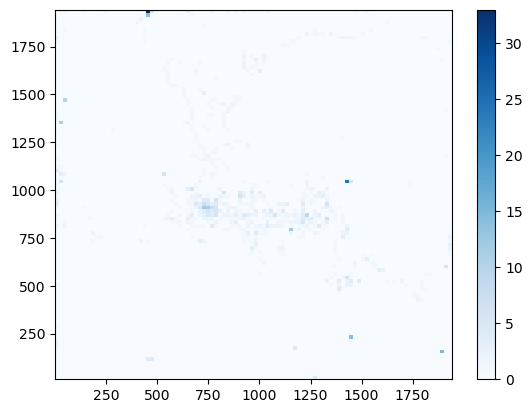

In [153]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
h = ax.hist2d(xs,ys,bins=100,cmap='Blues')#, norm=LogNorm())
fig.colorbar(h[3], ax=ax)


In [160]:
np.unique(tracksdf.ID.values)

array([   2.,    3.,    4., ..., 1992., 1998., 1999.])

In [168]:
startend.loc[119].end

120

In [171]:
tracksdf[np.isin(tracksdf.ID,idstodrop,invert=True)]

,ID,time,x,y
868,3.0,0.0,199.301587,724.611111
869,3.0,1.0,201.025000,724.166667
870,3.0,2.0,203.356589,723.286822
871,3.0,3.0,203.436620,723.359155
872,3.0,4.0,202.652893,722.619835
...,...,...,...,...
82341,1998.0,4306.0,41.700000,1079.700000
82342,1998.0,4307.0,41.939394,1079.787879
82343,1998.0,4308.0,41.821429,1079.892857
82344,1998.0,4309.0,42.478261,1080.782609


In [192]:
list(tracksdf[(tracksdf.ID==574) & (tracksdf.time==startend.loc[574].end)].values)[0]

array([ 574.    ,  843.    ,   32.1875, 1344.5   ])

In [196]:
combo,combotime,combox,comboy=list(tracksdf[(tracksdf.ID==574) & (tracksdf.time==startend.loc[574].end)].values)[0]

In [199]:
combo

574.0

In [200]:
for ID in np.unique(tracksdf.ID.values):
    if len(tracksdf[(tracksdf.ID==ID)&(np.abs(combotime-tracksdf.time)<20)&(np.abs(tracksdf.x-combox)<100)&(np.abs(tracksdf.y-comboy)<100)]):
        print(ID)

563.0
574.0


In [166]:
[i for i in np.unique(tracksdf.ID.values) if i not in np.asarray(leftscreen)]

[3.0,
 4.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 35.0,
 36.0,
 37.0,
 39.0,
 40.0,
 47.0,
 59.0,
 60.0,
 61.0,
 62.0,
 64.0,
 69.0,
 72.0,
 74.0,
 81.0,
 85.0,
 87.0,
 90.0,
 95.0,
 96.0,
 97.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 108.0,
 110.0,
 114.0,
 119.0,
 120.0,
 121.0,
 122.0,
 124.0,
 128.0,
 130.0,
 131.0,
 135.0,
 138.0,
 141.0,
 142.0,
 145.0,
 146.0,
 147.0,
 150.0,
 152.0,
 153.0,
 157.0,
 159.0,
 162.0,
 164.0,
 165.0,
 166.0,
 167.0,
 170.0,
 172.0,
 174.0,
 176.0,
 177.0,
 180.0,
 187.0,
 189.0,
 190.0,
 193.0,
 194.0,
 195.0,
 196.0,
 197.0,
 200.0,
 203.0,
 207.0,
 208.0,
 211.0,
 213.0,
 216.0,
 222.0,
 225.0,
 226.0,
 228.0,
 230.0,
 231.0,
 232.0,
 236.0,
 237.0,
 238.0,
 239.0,
 242.0,
 243.0,
 244.0,
 249.0,
 250.0,
 252.0,
 253.0,
 254.0,
 256.0,
 258.0,
 259.0,
 260.0,
 262.0,
 263.0,
 265.0,
 267.0,
 268.0,

In [165]:
xs=[]
ys=[]
leftscreen=[]
for ID in np.unique(tracksdf.ID.values):
    x=np.round(tracksdf[(tracksdf.ID==ID)&(tracksdf.time==startend.loc[ID].end)].x.values[0],1)
    y=np.round(tracksdf[(tracksdf.ID==ID)&(tracksdf.time==startend.loc[ID].end)].y.values[0],1)
    if (x<10) or (x>np.max(tracksdf.x)-10) or (y<10) or (y>np.max(tracksdf.y)-10):
           leftscreen.append(ID)
    xs.append(x)
    ys.append(y)
                
nbins=400
densityhist=np.histogram2d(xs,ys,bins=nbins)
densityindexes=np.unravel_index(np.argsort(a[0].flatten())[-30:-1], np.shape(np.histogram2d(xs,ys,bins=nbins)[0]))

repIDs=[]
for index1,index2 in tqdm(zip(densityindexes[0],densityindexes[1])):
    tx=densityhist[1][index1]
    ty=densityhist[1][index2]
    for ID in np.unique(tracksdf.ID.values):
        x=np.round(tracksdf[(tracksdf.ID==ID)&(tracksdf.time==startend.loc[ID].end)].x.values[0],1)
        y=np.round(tracksdf[(tracksdf.ID==ID)&(tracksdf.time==startend.loc[ID].end)].y.values[0],1)
        if (tx-5<x and x<tx+5) and (ty-5 < y and y < ty+5):
            if len(tracksdf[tracksdf.ID==ID])<5 or (np.max(tracksdf[tracksdf.ID==ID].x.values)-np.min(tracksdf[tracksdf.ID==ID].x.values)<10 and np.max(tracksdf[tracksdf.ID==ID].y.values)-np.min(tracksdf[tracksdf.ID==ID].y.values)<10):
                repIDs.append(ID)
                #print(str(int(ID)) + ": " + str(x) + " " + str(y) + ", time = " + str(int(startend.loc[ID].end)) + ", number = " + str(len(tracksdf[tracksdf.ID==ID])))

29it [00:35,  1.22s/it]


In [139]:
len(repIDs)

122

In [141]:
len(np.unique(tracksdf.ID.values))

1137

In [148]:
np.sort(repIDs)

array([ 553.,  560.,  596.,  618.,  626.,  630.,  637.,  638.,  645.,
        666.,  671.,  679.,  684.,  687.,  693.,  706.,  719.,  724.,
        725.,  731.,  770.,  778.,  805., 1011., 1013., 1100., 1390.,
       1390., 1390., 1390., 1395., 1395., 1395., 1395., 1406., 1406.,
       1406., 1406., 1410., 1410., 1410., 1410., 1412., 1414., 1414.,
       1414., 1414., 1433., 1433., 1433., 1433., 1434., 1434., 1434.,
       1434., 1441., 1441., 1441., 1441., 1475., 1475., 1475., 1475.,
       1476., 1476., 1476., 1476., 1494., 1494., 1494., 1494., 1558.,
       1562., 1575., 1578., 1584., 1586., 1684., 1684., 1700., 1700.,
       1710., 1710., 1727., 1727., 1729., 1729., 1730., 1733., 1733.,
       1737., 1737., 1742., 1742., 1744., 1744., 1750., 1750., 1756.,
       1756., 1760., 1760., 1851., 1851., 1861., 1863., 1866., 1872.,
       1884., 1885., 1892., 1898., 1903., 1903., 1904., 1904., 1926.,
       1926., 1938., 1941., 1941., 1984.])

In [150]:
tracksdf0=tracksdf
tracksdf[np.isin(tracksdf.ID,repIDs,invert=True)].ID

751         2.0
752         2.0
753         2.0
754         2.0
755         2.0
          ...  
82343    1998.0
82344    1998.0
82345    1998.0
82346    1999.0
82347    1999.0
Name: ID, Length: 76070, dtype: float64

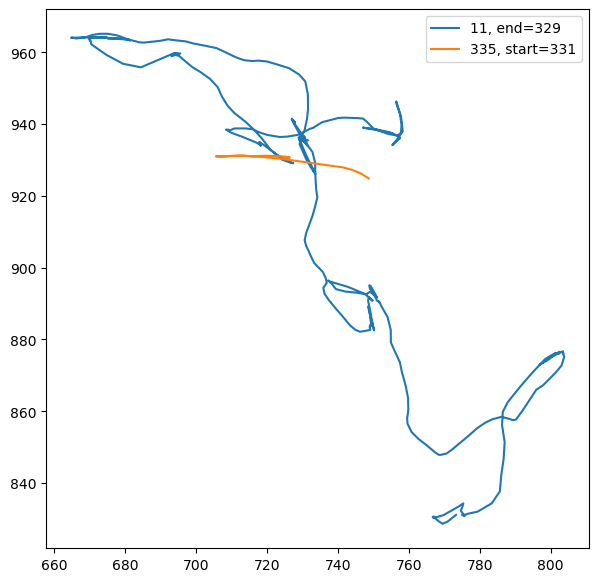

In [31]:

    f=plt.figure(figsize=(7,7)) #creates the figure
    
    ID1=11#stores IDs for the start and end track
    ID2=335#stores IDs for the start and end track
    
    #finds the difference between the last points of ID1
    diff1=(tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end-1)][["x","y"]].values[0])
    
    
    #finds the difference between the first points of ID2
    diff2=(tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start+1)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start)][["x","y"]].values[0])

    #plots the two IDs
    plt.plot(tracksdf[tracksdf.ID==ID1].x,
             tracksdf[tracksdf.ID==ID1].y,label=str(ID1)+", end="+str(startend.loc[ID1].end))
    plt.plot(tracksdf[tracksdf.ID==ID2].x,
             tracksdf[tracksdf.ID==ID2].y,label=str(ID2)+", start="+str(startend.loc[ID2].start))

    #finds the location of the end of ID1
    ID1end=tracksdf[(tracksdf.ID==ID1)&(tracksdf.time==max(tracksdf[tracksdf.ID==ID1].time))][["x","y"]].values[0]
    
    #finds the location of the start of ID2
    ID2start=tracksdf[(tracksdf.ID==ID2)&(tracksdf.time==min(tracksdf[tracksdf.ID==ID2].time))][["x","y"]].values[0]
    
    #print(diff1)
    #print(diff2)
    #print(np.arctan2(diff1[1],diff1[0])*(180/np.pi))
    #print(np.arctan2(diff2[1],diff2[0])*(180/np.pi))
    
    #print(np.min([np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
    #              360-np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi)]))
    plt.legend()
    plt.show()

In [16]:
dists=[]
angles=[]
lengths=np.zeros([len(possiblecombos.index),2])
for i in tqdm(range(len(possiblecombos.index))):
    ID1=int(possiblecombos[possiblecombos.index==i].ID1)#stores IDs for the start and end track
    ID2=int(possiblecombos[possiblecombos.index==i].ID2)#stores IDs for the start and end track
    lengths[i,:]=[len(tracksdf[tracksdf.ID==ID1]),len(tracksdf[tracksdf.ID==ID2])] #stores the lengths of each track
    
    #finds the difference between the last points of ID1
    diff1=(tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end-1)][["x","y"]].values[0])
    #finds the difference between the first points of ID2
    diff2=(tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start+1)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start)][["x","y"]].values[0])
    #finds the location of the end of ID1
    ID1end=tracksdf[(tracksdf.ID==ID1)&(tracksdf.time==max(tracksdf[tracksdf.ID==ID1].time))][["x","y"]].values[0]
    
    #finds the location of the start of ID2
    ID2start=tracksdf[(tracksdf.ID==ID2)&(tracksdf.time==min(tracksdf[tracksdf.ID==ID2].time))][["x","y"]].values[0]
    
    #finds the distance between the predicted points
    dist = np.sqrt(np.sum(np.square(ID1end+diff1*(int(possiblecombos[possiblecombos.index==i].start)
                                              -int(possiblecombos[possiblecombos.index==i].end))/2
                                    -(ID2start-diff2*(int(possiblecombos[possiblecombos.index==i].start)
                                                  -int(possiblecombos[possiblecombos.index==i].end))/2))))
    angle = np.min([np.abs(np.arctan2(diff1[1],diff1[0])
                           -np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
                    360-np.abs(np.arctan2(diff1[1],diff1[0])
                               -np.arctan2(diff2[1],diff2[0]))*(180/np.pi)])
    dists.append(dist)
    angles.append(angle)

100%|███████████████████████████████████████████████████████████████████████████████| 876/876 [00:06<00:00, 137.60it/s]


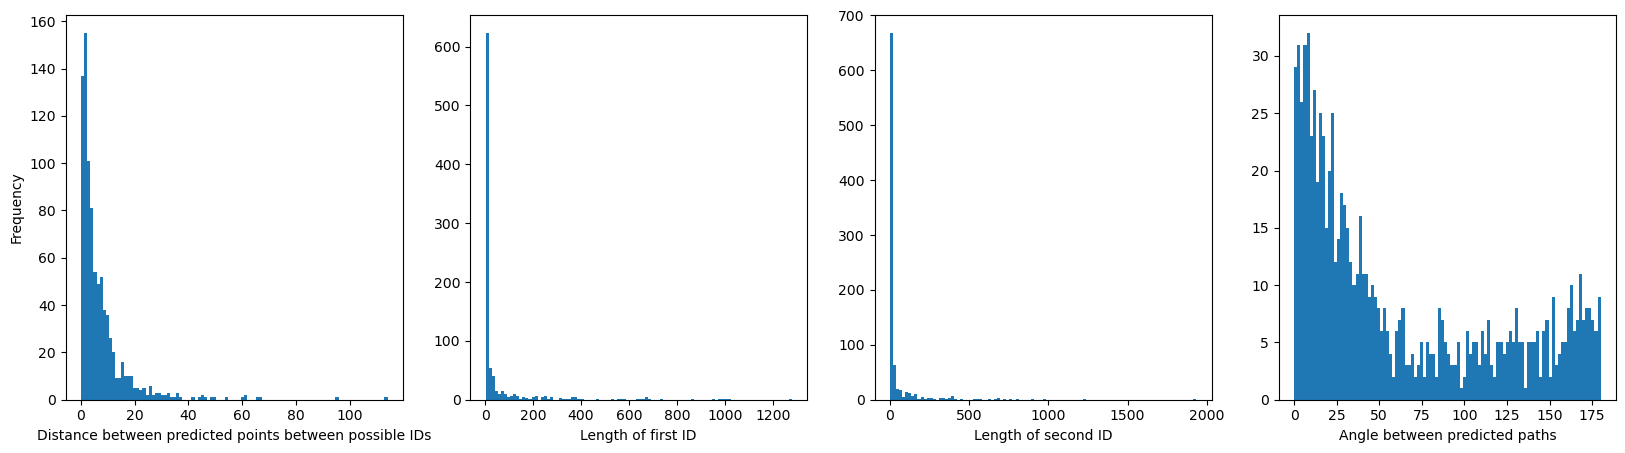

In [17]:
f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, sharey=False, figsize=(20,5))
ax1.hist(dists,bins=100)
ax1.set_xlabel("Distance between predicted points between possible IDs")
ax1.set_ylabel("Frequency")


ax2.hist(lengths[:,0],bins=100)
ax2.set_xlabel("Length of first ID")


ax3.hist(lengths[:,1],bins=100)
ax3.set_xlabel("Length of second ID")


ax4.hist(angles,bins=100)
ax4.set_xlabel("Angle between predicted paths");

We should link multiple points that are clearly in a sequence:

In [18]:
confirmeds=np.nonzero((np.asarray(dists)<10)
                      & (np.sum(lengths,axis=1)>=15)
                      & (lengths[:,0]>=4)
                      & (lengths[:,1]>4)
                      & (np.asarray(angles)<60))[0]
if np.any(np.unique(possiblecombos.loc[confirmeds].ID1,return_counts=True)[1]!=1) or np.any(np.unique(possiblecombos.loc[confirmeds].ID2,return_counts=True)[1]!=1):
    print("ERROR: PRELIMINARY CLASSIFICATION FAILED: DUPLICATE MADE")
    
idstodrop=[]
for i in confirmeds: #i represents the index of correct combo
    ID1,ID2=possiblecombos.loc[i][["ID1","ID2"]].values
    tracksdf.loc[tracksdf.ID==ID2,["ID"]]=ID1
    idstodrop.append(np.asarray(possiblecombos[possiblecombos.ID2==ID2].index))

Must run start and end and combos again:

In [19]:
#creates dataframe with start and end times for each ID
startend=pd.DataFrame(columns=["start","end"])
for ID in np.unique(tracksdf.ID).astype(int):
    startend.loc[ID,:]=int(np.min(tracksdf.loc[tracksdf.ID==ID].time)),int(np.max(tracksdf.loc[tracksdf.ID==ID].time))
startend.astype(int);

In [20]:
#gets all possible combinations of two indexes within 10 frames and 20 distance
possiblecombos=pd.DataFrame(columns=["ID1","ID2","end","start"])#,"dist"])
for ID in tqdm(np.unique(tracksdf.ID)):
    endindex=startend.loc[ID].end
    endlocation=tracksdf.loc[(tracksdf.ID==ID) & (tracksdf.time==endindex),["x","y"]].values
    for end in range(endindex,endindex+10):
        if end+1 in list(startend.start):
            for startID in startend.index[startend.start==end+1]:
                startlocation=tracksdf.loc[(tracksdf.ID==startID) & (tracksdf.time==end+1),["x","y"]].values
                if np.linalg.norm(startlocation-endlocation) < 20:
                    possiblecombos.loc[len(possiblecombos.index)] = [int(ID),startID,endindex,end+1]#,np.linalg.norm(startlocation-endlocation)] 
                    #print("first ID: "+str(int(ID))+", second ID: "+str(startID)+", difference in times: "+str(endindex),str(end+1)+", distance: "+str(np.linalg.norm(startlocation-endlocation)))

100%|█████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:05<00:00, 191.66it/s]


In [21]:
combos=[]
for ID in tqdm(np.unique(tracksdf.ID).astype(int)):
    combo=list(np.flip(findpairreverse(ID,[],possiblecombos))[:-1])+findpair(ID,[],possiblecombos)
    len(combo)>1 and combos.append(sorted(combo))

100%|█████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:01<00:00, 798.38it/s]


In [22]:
uniquecombos=[]
for combo in combos:
    if combo not in uniquecombos:
        uniquecombos.append(combo)
combos=uniquecombos

In [23]:
startend.loc[193]

start    115
end      258
Name: 193, dtype: object

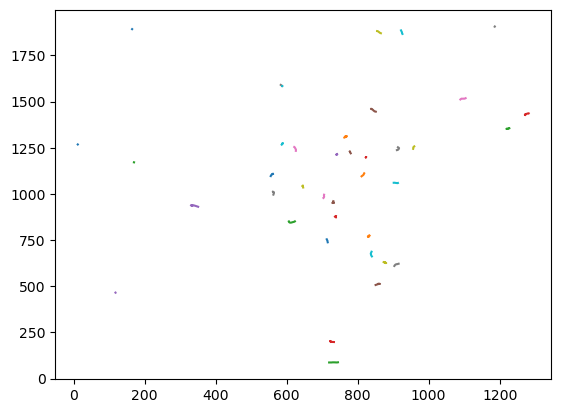

In [24]:
for ID in range(1000):
    vals=tracksdf[(tracksdf.ID==ID)&(tracksdf.time<10)][["x","y"]].values
    plt.plot(vals[:,1],vals[:,0])

In [25]:
x,y=tracksdf[(tracksdf.ID==11)&(tracksdf.time==startend.loc[11].end)][["x","y"]].values[0]

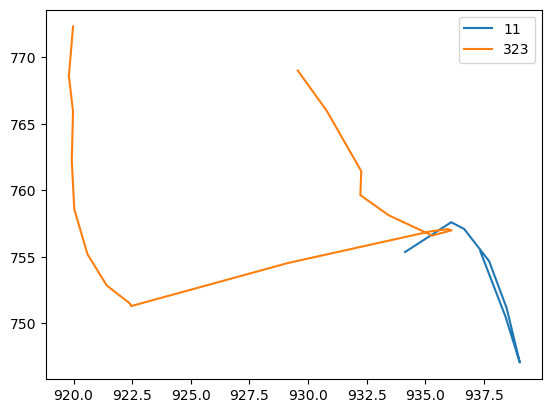

In [26]:
for ID in [11,323]:
    vals=tracksdf[(tracksdf.ID==ID)&(tracksdf.time>320)&(tracksdf.time<340)][["x","y"]].values
    plt.plot(vals[:,1],vals[:,0],label=ID)
plt.legend()

In [100]:
dist=100
tracksdf[(tracksdf.time==startend.loc[11].end+2)&(tracksdf.x<x+dist)&(tracksdf.x>x-dist)&(tracksdf.y<y+dist)&(tracksdf.y>y-dist)]

,ID,time,x,y
21155,323.0,331.0,756.913793,935.224138
21287,335.0,331.0,748.752688,924.849462


In [76]:
startend.loc[11]

start      0
end      329
Name: 11, dtype: object

In [ ]:
sumarray=np.zeros(np.shape(images["1"]['frame'][0].max(2)))
for i in tqdm(np.asarray(list(images.keys()))[:-1]):
    sumarray+=images[i]['frame'][0].max(2)

 97%|███████████████████████████████████████████████████████████████████████████▉  | 4197/4313 [02:56<00:02, 44.50it/s]

In [6]:
images = h5py.File("../data/202304051.h5",'r+') 

In [11]:
sumarray=np.load("sumarray.npy")

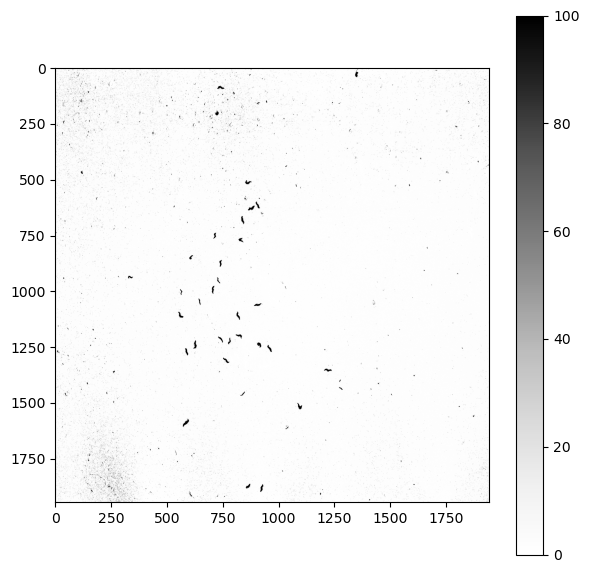

In [12]:
fig=plt.figure(figsize=(7,7))
img=images["2"]['frame'][0].max(2)-sumarray/max(np.asarray(list(images.keys()))[:-1].astype(int))
img=np.vectorize(lambda x: 0 if x < 0 else x)(img)
img=np.vectorize(lambda x: 100 if x > 5 else x)(img)
plt.imshow(img,cmap="Greys")
plt.colorbar()